# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

## Caveats:

- The confirmed cases reported by each country are different from the number of infected people in each country.


- **The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infected people.** For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but the actual cases may not be rising as the same rate.


- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.


- The growth rate (or recent doubling time) changes with time, and will eventually fall to zero. So be cautious about extrapolating trends into the future based on current growth rates. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/17/20


,3/17/20
Country/Region,
China,81058
Italy,31506
Iran,16169
Spain,11748
Germany,9257
"Korea, South",8320
France,7699
US,6421
Switzerland,2700


## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 81058
	Confirmed cases on 3/10/20 	 80887
	Ratio: 1.0
	Weekly increase: 0.2 %
	Daily increase: 0.0 % per day
	Doubling Time (represents recent growth): 2297.5 days

** Based on Logistic Fit**

	R^2: 0.99518690538
	Doubling Time (during middle of growth):  6.46 (± 0.56 ) days


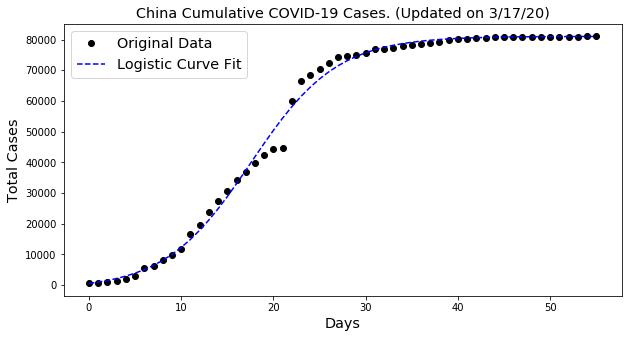



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 31506
	Confirmed cases on 3/10/20 	 10149
	Ratio: 3.1
	Weekly increase: 210.4 %
	Daily increase: 17.6 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.997549477042
	Doubling Time (during middle of growth):  6.45 (± 0.56 ) days

** Based on Exponential Fit **

	R^2: 0.995247807212
	Doubling Time (represents overall growth):  4.07 (± 0.18 ) days


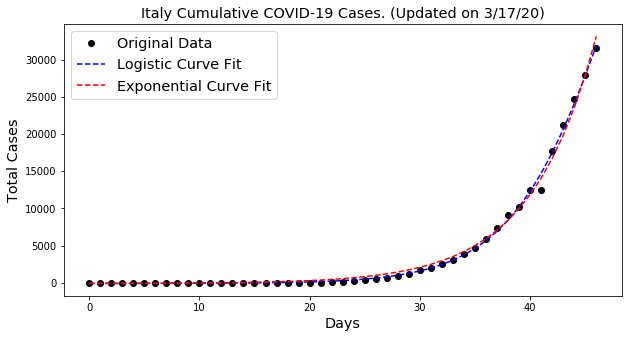



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 16169
	Confirmed cases on 3/10/20 	 8042
	Ratio: 2.01
	Weekly increase: 101.1 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.996689927378
	Doubling Time (during middle of growth):  6.6 (± 0.95 ) days


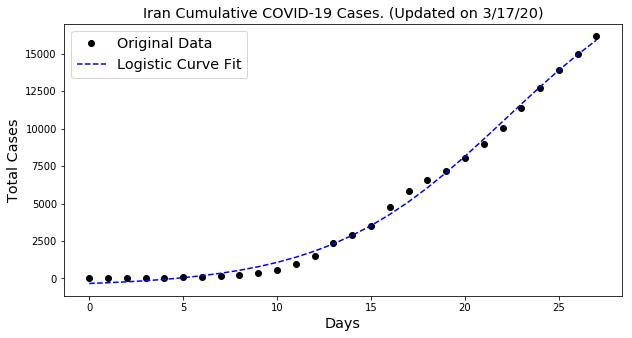



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 11748
	Confirmed cases on 3/10/20 	 1695
	Ratio: 6.93
	Weekly increase: 593.1 %
	Daily increase: 31.9 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Exponential Fit **

	R^2: 0.987309613463
	Doubling Time (represents overall growth):  2.63 (± 0.18 ) days


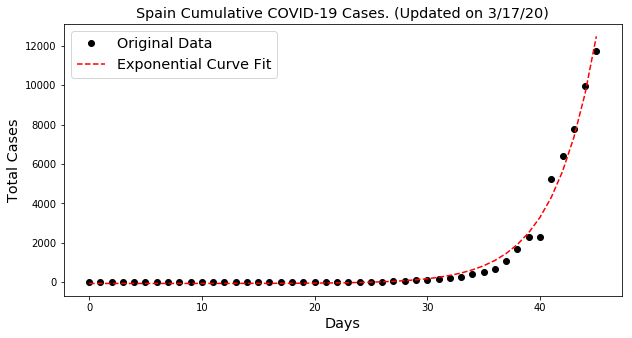



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 9257
	Confirmed cases on 3/10/20 	 1457
	Ratio: 6.35
	Weekly increase: 535.3 %
	Daily increase: 30.2 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Exponential Fit **

	R^2: 0.997057801078
	Doubling Time (represents overall growth):  2.71 (± 0.09 ) days


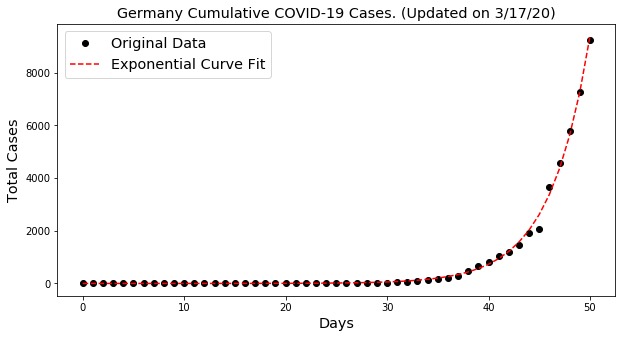



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 8320
	Confirmed cases on 3/10/20 	 7513
	Ratio: 1.11
	Weekly increase: 10.7 %
	Daily increase: 1.5 % per day
	Doubling Time (represents recent growth): 47.6 days

** Based on Logistic Fit**

	R^2: 0.999488403416
	Doubling Time (during middle of growth):  4.1 (± 0.12 ) days


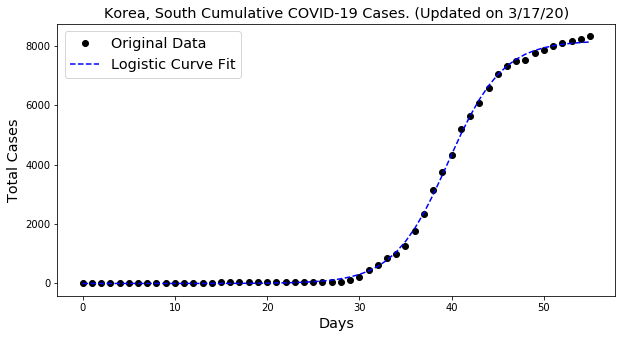



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 7699
	Confirmed cases on 3/10/20 	 1792
	Ratio: 4.3
	Weekly increase: 329.6 %
	Daily increase: 23.2 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.992525780799
	Doubling Time (represents overall growth):  3.19 (± 0.16 ) days


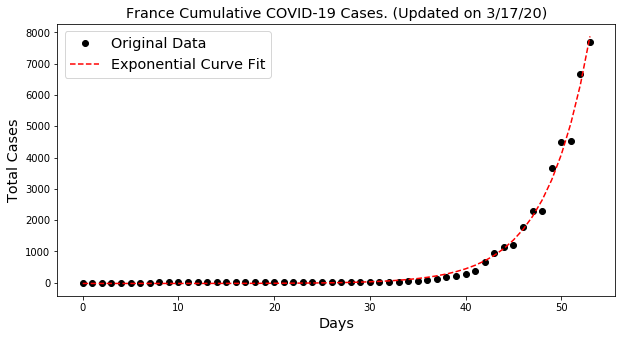



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 6421
	Confirmed cases on 3/10/20 	 959
	Ratio: 6.7
	Weekly increase: 569.6 %
	Daily increase: 31.2 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Exponential Fit **

	R^2: 0.998839827871
	Doubling Time (represents overall growth):  2.49 (± 0.05 ) days


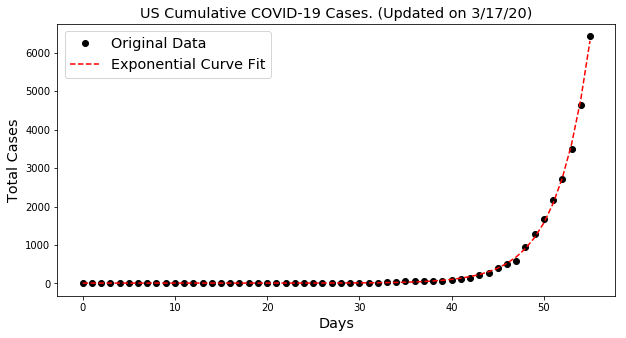



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 2700
	Confirmed cases on 3/10/20 	 491
	Ratio: 5.5
	Weekly increase: 449.9 %
	Daily increase: 27.6 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.985570401278
	Doubling Time (during middle of growth):  3.81 (± 1.25 ) days

** Based on Exponential Fit **

	R^2: 0.981501513234
	Doubling Time (represents overall growth):  3.06 (± 0.45 ) days


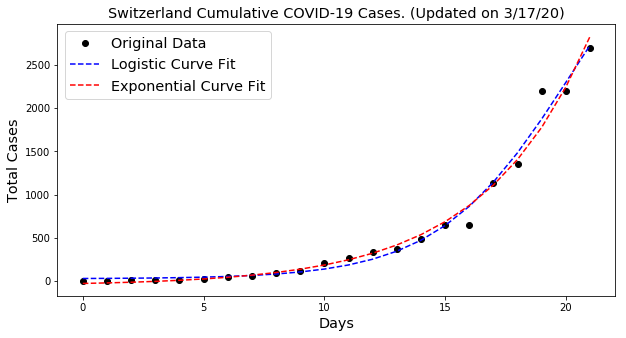



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 1960
	Confirmed cases on 3/10/20 	 384
	Ratio: 5.1
	Weekly increase: 410.4 %
	Daily increase: 26.2 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Exponential Fit **

	R^2: 0.992353006895
	Doubling Time (represents overall growth):  2.95 (± 0.16 ) days


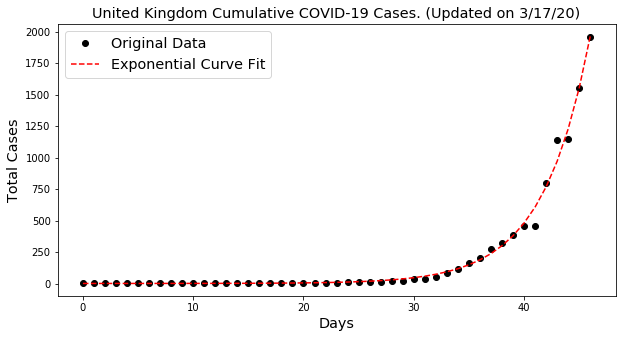



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 1708
	Confirmed cases on 3/10/20 	 382
	Ratio: 4.47
	Weekly increase: 347.1 %
	Daily increase: 23.9 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.996408599146
	Doubling Time (during middle of growth):  6.15 (± 1.64 ) days

** Based on Exponential Fit **

	R^2: 0.996184777452
	Doubling Time (represents overall growth):  3.54 (± 0.28 ) days


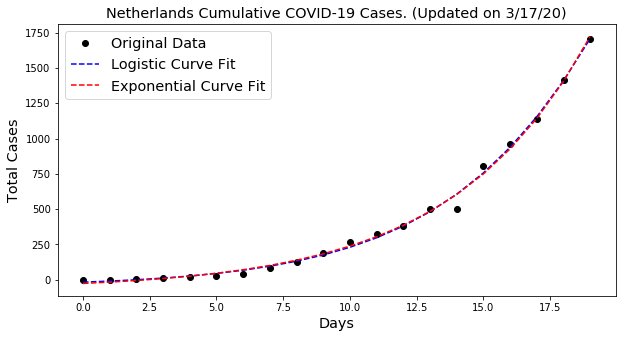



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 1463
	Confirmed cases on 3/10/20 	 400
	Ratio: 3.66
	Weekly increase: 265.8 %
	Daily increase: 20.4 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.996553886221
	Doubling Time (during middle of growth):  2.83 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.968678039177
	Doubling Time (represents overall growth):  4.17 (± 1.0 ) days


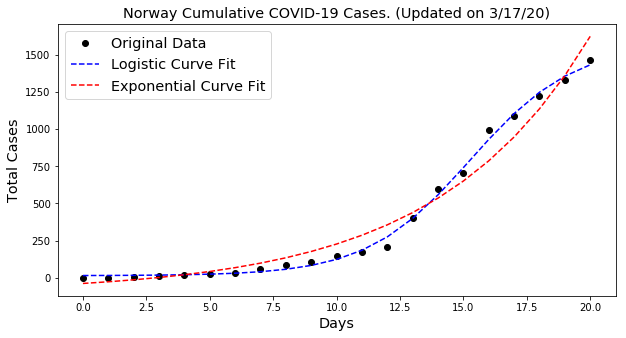



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 1332
	Confirmed cases on 3/10/20 	 182
	Ratio: 7.32
	Weekly increase: 631.9 %
	Daily increase: 32.9 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.997731028869
	Doubling Time (during middle of growth):  3.83 (± 0.52 ) days

** Based on Exponential Fit **

	R^2: 0.995505989588
	Doubling Time (represents overall growth):  2.66 (± 0.18 ) days


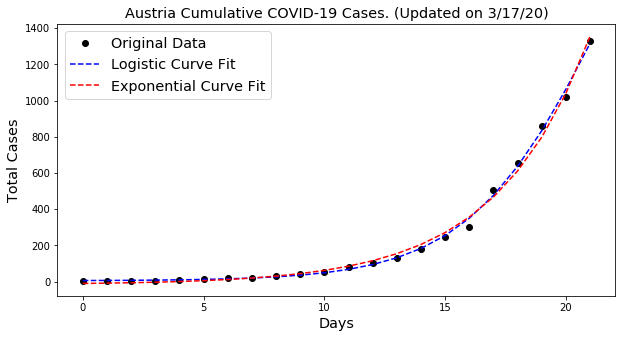



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 1243
	Confirmed cases on 3/10/20 	 267
	Ratio: 4.66
	Weekly increase: 365.5 %
	Daily increase: 24.6 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Exponential Fit **

	R^2: 0.991754617834
	Doubling Time (represents overall growth):  3.11 (± 0.18 ) days


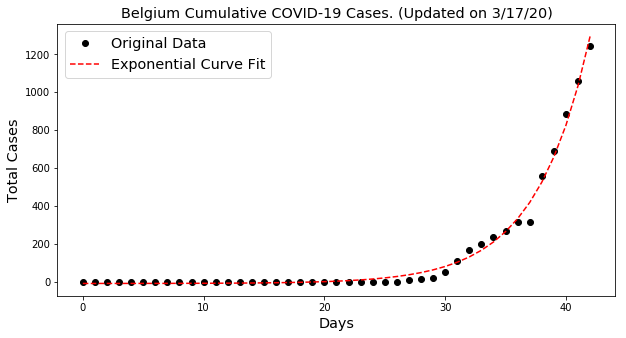



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 1190
	Confirmed cases on 3/10/20 	 355
	Ratio: 3.35
	Weekly increase: 235.2 %
	Daily increase: 18.9 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Exponential Fit **

	R^2: 0.971764064649
	Doubling Time (represents overall growth):  3.92 (± 0.42 ) days


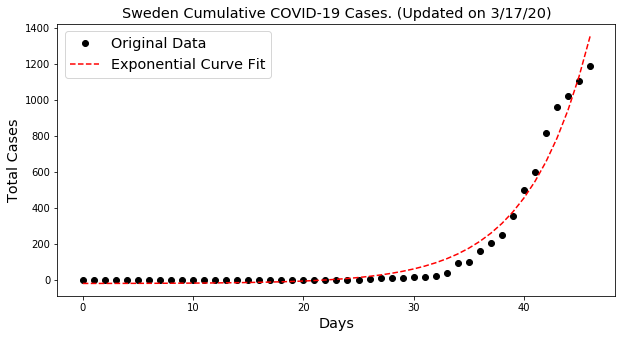



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 1024
	Confirmed cases on 3/10/20 	 264
	Ratio: 3.88
	Weekly increase: 287.9 %
	Daily increase: 21.4 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.995937246733
	Doubling Time (during middle of growth):  1.67 (± 0.25 ) days


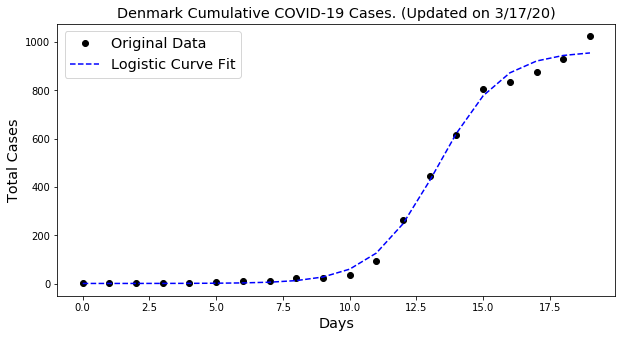



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 878
	Confirmed cases on 3/10/20 	 581
	Ratio: 1.51
	Weekly increase: 51.1 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.8 days

** Based on Logistic Fit**

	R^2: 0.99747411023
	Doubling Time (during middle of growth):  12.02 (± 1.04 ) days

** Based on Exponential Fit **

	R^2: 0.993900900827
	Doubling Time (represents overall growth):  9.32 (± 0.51 ) days


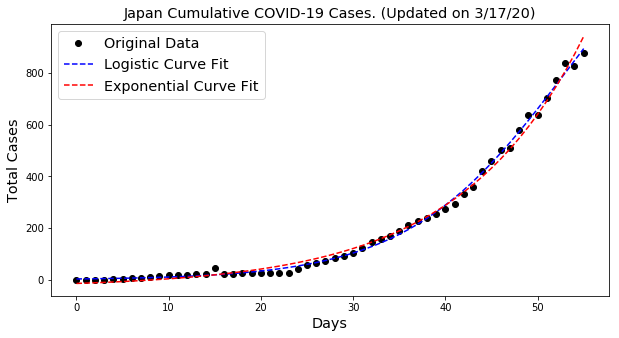



Cruise Ship

** Based on Logistic Fit**

	R^2: 0.9956796271
	Doubling Time (during middle of growth):  2.68 (± 0.28 ) days


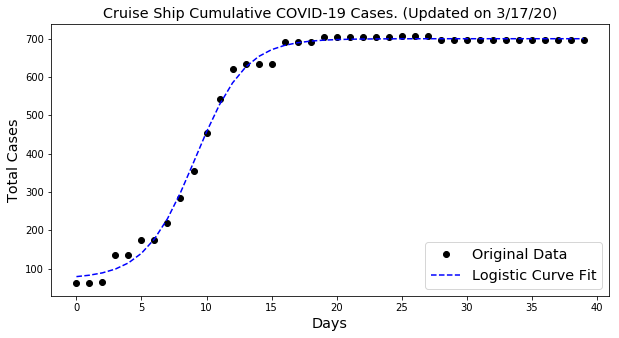



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 673
	Confirmed cases on 3/10/20 	 129
	Ratio: 5.22
	Weekly increase: 421.7 %
	Daily increase: 26.6 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.982026467613
	Doubling Time (represents overall growth):  2.49 (± 0.19 ) days


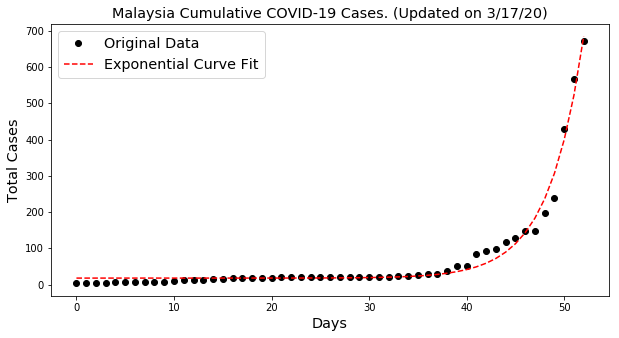



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 478
	Confirmed cases on 3/10/20 	 79
	Ratio: 6.05
	Weekly increase: 505.1 %
	Daily increase: 29.3 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Exponential Fit **

	R^2: 0.987548203843
	Doubling Time (represents overall growth):  2.66 (± 0.17 ) days


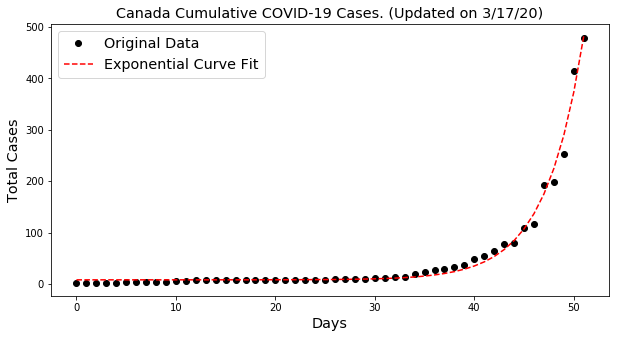



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 452
	Confirmed cases on 3/10/20 	 107
	Ratio: 4.22
	Weekly increase: 322.4 %
	Daily increase: 22.9 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.995367834753
	Doubling Time (represents overall growth):  3.14 (± 0.12 ) days


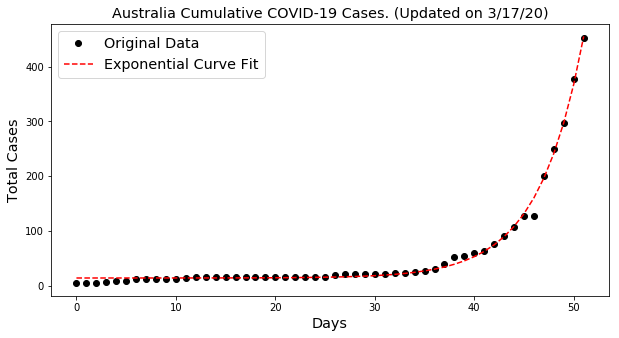



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 448
	Confirmed cases on 3/10/20 	 41
	Ratio: 10.93
	Weekly increase: 992.7 %
	Daily increase: 40.7 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.997369469654
	Doubling Time (during middle of growth):  3.1 (± 0.6 ) days

** Based on Exponential Fit **

	R^2: 0.996096729404
	Doubling Time (represents overall growth):  2.05 (± 0.16 ) days


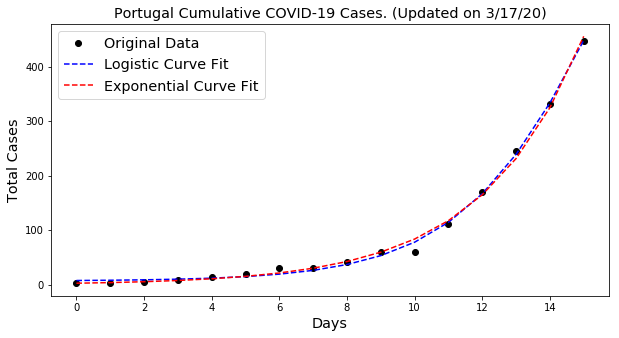



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 439
	Confirmed cases on 3/10/20 	 24
	Ratio: 18.29
	Weekly increase: 1729.2 %
	Daily increase: 51.5 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Logistic Fit**

	R^2: 0.967866151737
	Doubling Time (during middle of growth):  1.52 (± 0.69 ) days


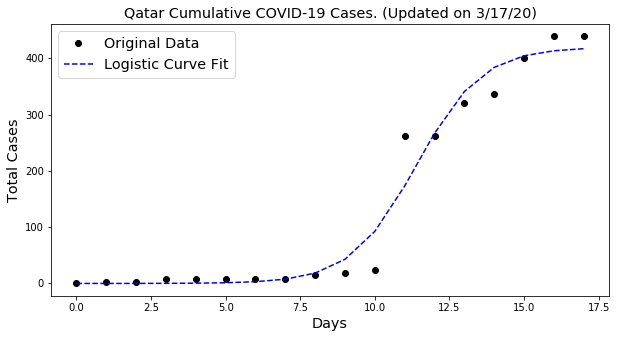



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 396
	Confirmed cases on 3/10/20 	 41
	Ratio: 9.66
	Weekly increase: 865.9 %
	Daily increase: 38.3 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.995907339888
	Doubling Time (during middle of growth):  3.94 (± 0.97 ) days

** Based on Exponential Fit **

	R^2: 0.994369430241
	Doubling Time (represents overall growth):  2.71 (± 0.27 ) days


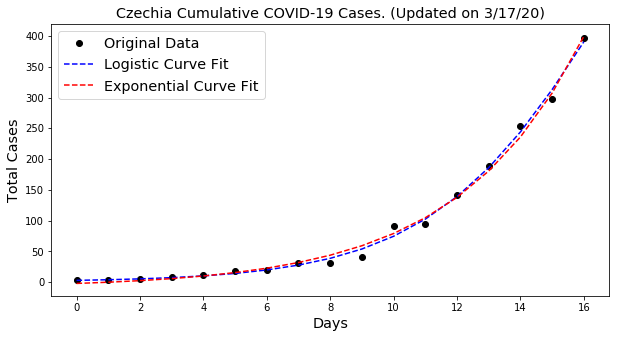



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 387
	Confirmed cases on 3/10/20 	 89
	Ratio: 4.35
	Weekly increase: 334.8 %
	Daily increase: 23.4 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.980059443918
	Doubling Time (during middle of growth):  4.17 (± 1.72 ) days

** Based on Exponential Fit **

	R^2: 0.975913841831
	Doubling Time (represents overall growth):  3.51 (± 0.66 ) days


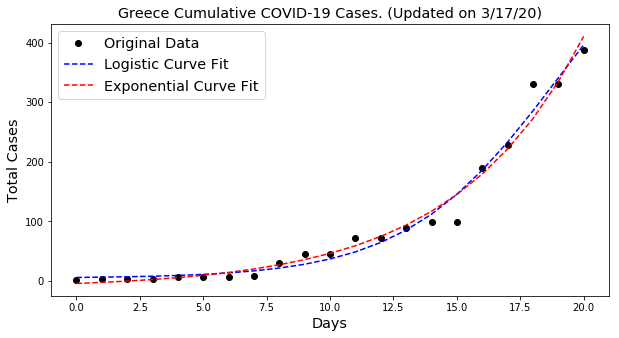



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 337
	Confirmed cases on 3/10/20 	 83
	Ratio: 4.06
	Weekly increase: 306.0 %
	Daily increase: 22.2 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.994931427256
	Doubling Time (during middle of growth):  5.7 (± 1.15 ) days

** Based on Exponential Fit **

	R^2: 0.993612267309
	Doubling Time (represents overall growth):  3.72 (± 0.3 ) days


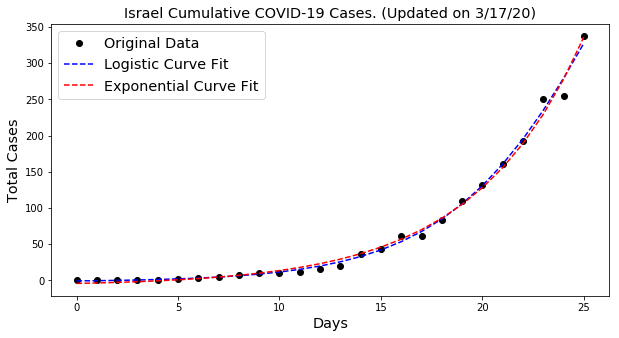



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 321
	Confirmed cases on 3/10/20 	 31
	Ratio: 10.35
	Weekly increase: 935.5 %
	Daily increase: 39.6 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.964534160006
	Doubling Time (during middle of growth):  4.94 (± 3.56 ) days

** Based on Exponential Fit **

	R^2: 0.964534162123
	Doubling Time (represents overall growth):  2.47 (± 0.5 ) days


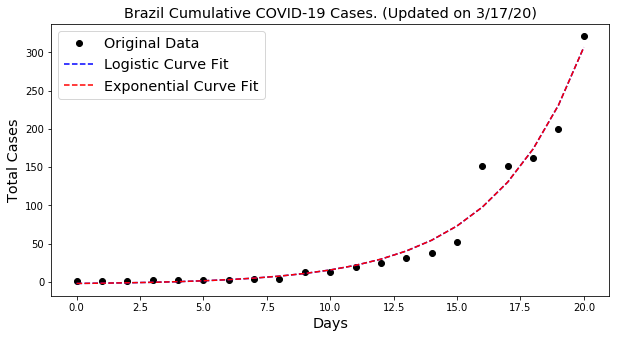



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 321
	Confirmed cases on 3/10/20 	 40
	Ratio: 8.02
	Weekly increase: 702.5 %
	Daily increase: 34.7 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Exponential Fit **

	R^2: 0.965988261742
	Doubling Time (represents overall growth):  2.77 (± 0.31 ) days


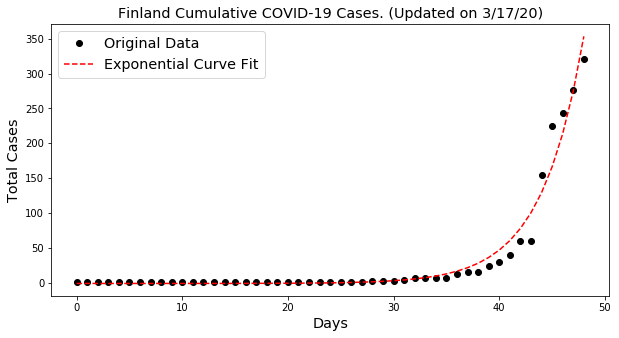



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 275
	Confirmed cases on 3/10/20 	 31
	Ratio: 8.87
	Weekly increase: 787.1 %
	Daily increase: 36.6 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.999127983725
	Doubling Time (during middle of growth):  2.17 (± 0.21 ) days

** Based on Exponential Fit **

	R^2: 0.973862934683
	Doubling Time (represents overall growth):  4.46 (± 1.93 ) days


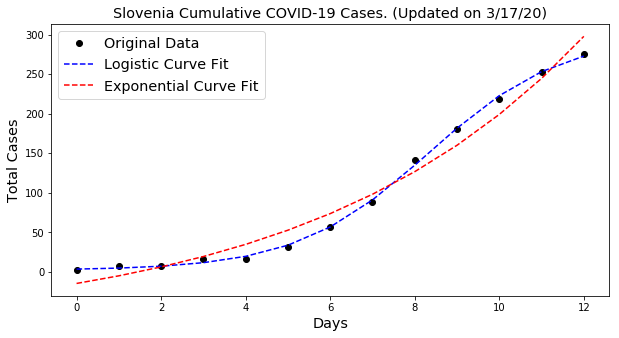



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 266
	Confirmed cases on 3/10/20 	 160
	Ratio: 1.66
	Weekly increase: 66.3 %
	Daily increase: 7.5 % per day
	Doubling Time (represents recent growth): 9.5 days

** Based on Logistic Fit**

	R^2: 0.970180834966
	Doubling Time (during middle of growth):  34.15 (± 7.86 ) days

** Based on Exponential Fit **

	R^2: 0.970180836161
	Doubling Time (represents overall growth):  17.07 (± 3.15 ) days


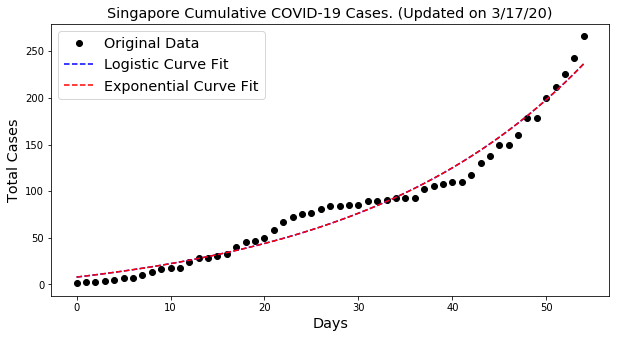



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 238
	Confirmed cases on 3/10/20 	 22
	Ratio: 10.82
	Weekly increase: 981.8 %
	Daily increase: 40.5 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.997113099181
	Doubling Time (during middle of growth):  4.42 (± 1.46 ) days

** Based on Exponential Fit **

	R^2: 0.997095842948
	Doubling Time (represents overall growth):  2.3 (± 0.19 ) days


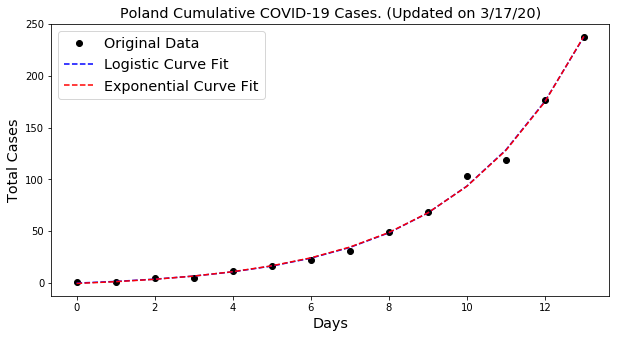



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 236
	Confirmed cases on 3/10/20 	 16
	Ratio: 14.75
	Weekly increase: 1375.0 %
	Daily increase: 46.9 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Exponential Fit **

	R^2: 0.989997028345
	Doubling Time (represents overall growth):  1.04 (± 0.11 ) days


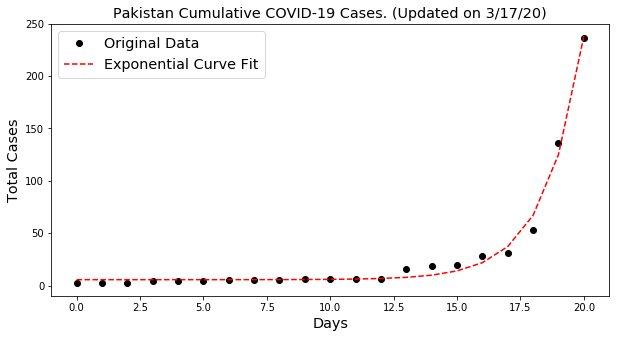



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 228
	Confirmed cases on 3/10/20 	 110
	Ratio: 2.07
	Weekly increase: 107.3 %
	Daily increase: 11.0 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.96552286135
	Doubling Time (during middle of growth):  2.85 (± 1.11 ) days


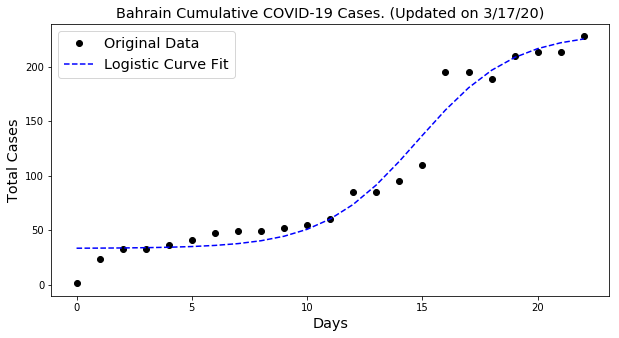



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 225
	Confirmed cases on 3/10/20 	 12
	Ratio: 18.75
	Weekly increase: 1775.0 %
	Daily increase: 52.0 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Logistic Fit**

	R^2: 0.993958858138
	Doubling Time (during middle of growth):  1.41 (± 0.26 ) days

** Based on Exponential Fit **

	R^2: 0.953033684015
	Doubling Time (represents overall growth):  2.34 (± 0.56 ) days


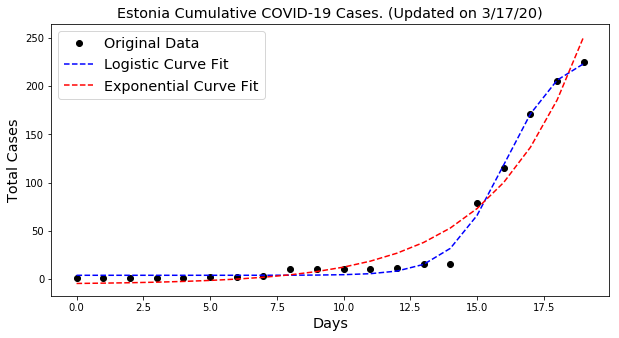



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 223
	Confirmed cases on 3/10/20 	 34
	Ratio: 6.56
	Weekly increase: 555.9 %
	Daily increase: 30.8 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.984564428329
	Doubling Time (during middle of growth):  4.22 (± 1.97 ) days

** Based on Exponential Fit **

	R^2: 0.983460999971
	Doubling Time (represents overall growth):  2.81 (± 0.47 ) days


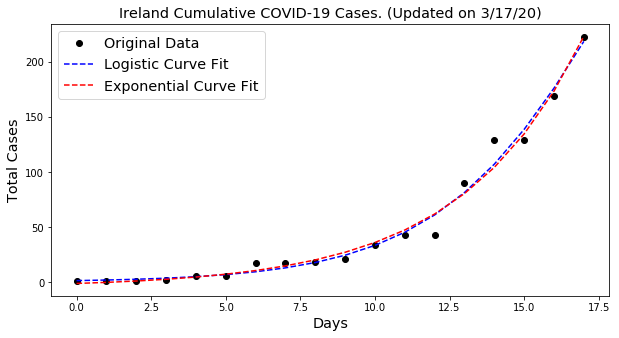



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 220
	Confirmed cases on 3/10/20 	 69
	Ratio: 3.19
	Weekly increase: 218.8 %
	Daily increase: 18.0 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.991126759018
	Doubling Time (during middle of growth):  8.65 (± 5.78 ) days

** Based on Exponential Fit **

	R^2: 0.990851237759
	Doubling Time (represents overall growth):  5.84 (± 1.06 ) days


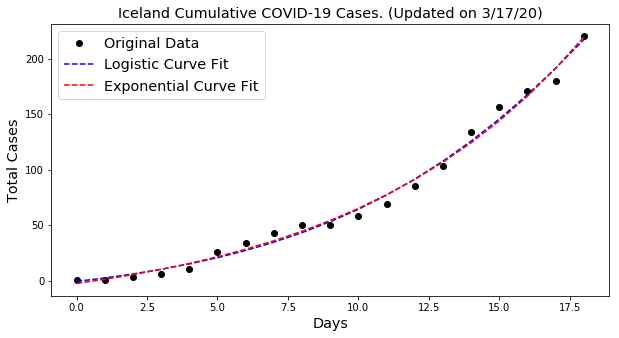



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 201
	Confirmed cases on 3/10/20 	 13
	Ratio: 15.46
	Weekly increase: 1446.2 %
	Daily increase: 47.9 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Logistic Fit**

	R^2: 0.986898701449
	Doubling Time (during middle of growth):  2.78 (± 1.32 ) days

** Based on Exponential Fit **

	R^2: 0.986324751004
	Doubling Time (represents overall growth):  1.67 (± 0.26 ) days


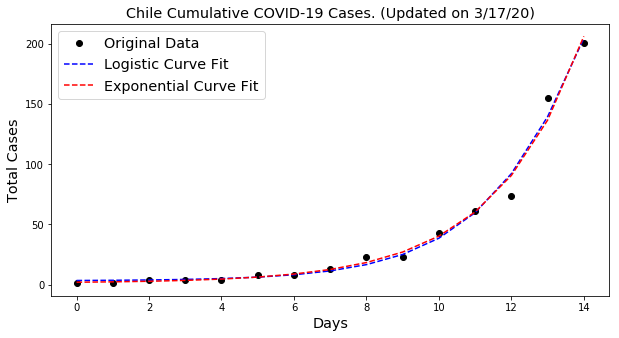



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 196
	Confirmed cases on 3/10/20 	 59
	Ratio: 3.32
	Weekly increase: 232.2 %
	Daily increase: 18.7 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Logistic Fit**

	R^2: 0.976919295563
	Doubling Time (during middle of growth):  7.06 (± 2.92 ) days

** Based on Exponential Fit **

	R^2: 0.976919296371
	Doubling Time (represents overall growth):  3.53 (± 0.43 ) days


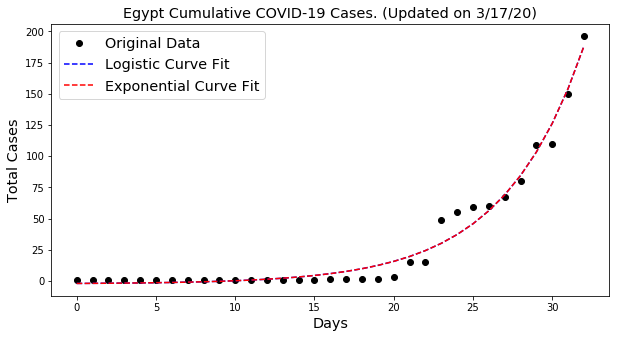



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 187
	Confirmed cases on 3/10/20 	 33
	Ratio: 5.67
	Weekly increase: 466.7 %
	Daily increase: 28.1 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.979978145828
	Doubling Time (represents overall growth):  2.72 (± 0.23 ) days


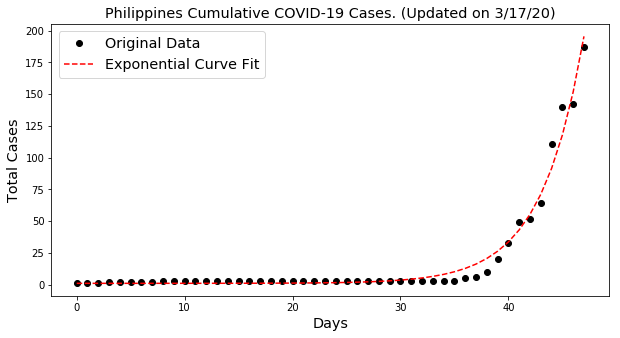



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 184
	Confirmed cases on 3/10/20 	 25
	Ratio: 7.36
	Weekly increase: 636.0 %
	Daily increase: 33.0 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.993853562818
	Doubling Time (during middle of growth):  2.62 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.976039581863
	Doubling Time (represents overall growth):  3.11 (± 0.56 ) days


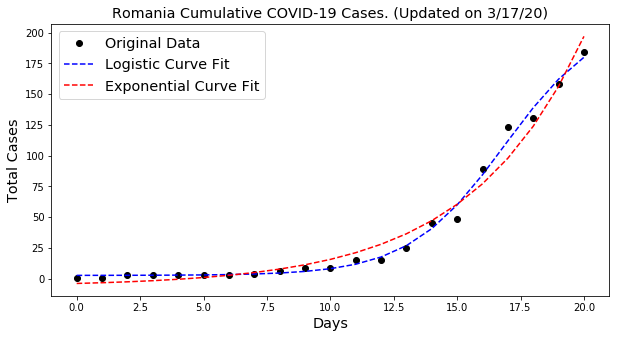



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 177
	Confirmed cases on 3/10/20 	 53
	Ratio: 3.34
	Weekly increase: 234.0 %
	Daily increase: 18.8 % per day
	Doubling Time (represents recent growth): 4.0 days


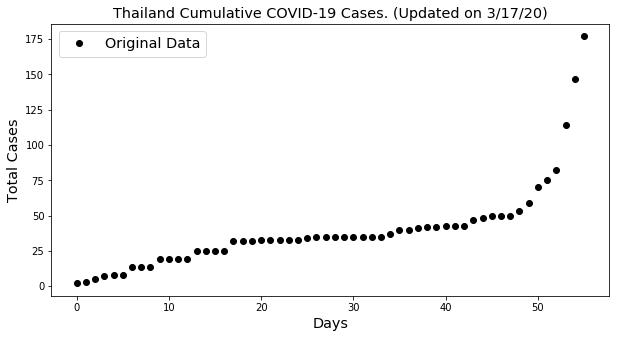



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 172
	Confirmed cases on 3/10/20 	 27
	Ratio: 6.37
	Weekly increase: 537.0 %
	Daily increase: 30.3 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.99165214449
	Doubling Time (during middle of growth):  3.18 (± 0.98 ) days

** Based on Exponential Fit **

	R^2: 0.985194591714
	Doubling Time (represents overall growth):  3.0 (± 0.55 ) days


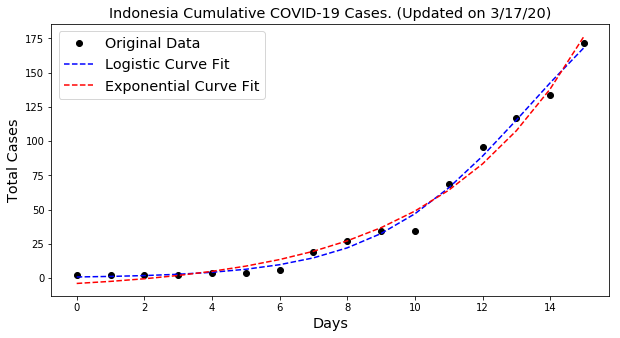



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 171
	Confirmed cases on 3/10/20 	 20
	Ratio: 8.55
	Weekly increase: 755.0 %
	Daily increase: 35.9 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.968651202628
	Doubling Time (during middle of growth):  3.23 (± 1.93 ) days

** Based on Exponential Fit **

	R^2: 0.962780766692
	Doubling Time (represents overall growth):  3.21 (± 0.99 ) days


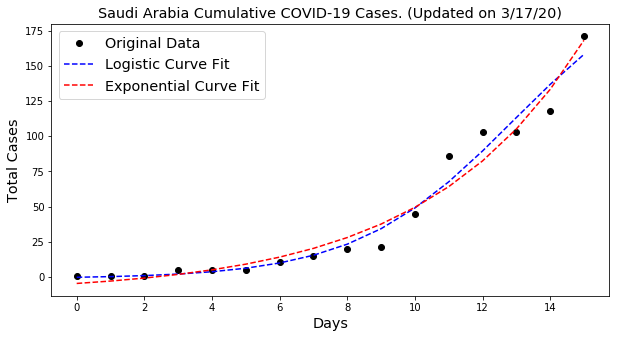



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 154
	Confirmed cases on 3/10/20 	 71
	Ratio: 2.17
	Weekly increase: 116.9 %
	Daily increase: 11.7 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.985486453484
	Doubling Time (during middle of growth):  16.49 (± 4.93 ) days

** Based on Exponential Fit **

	R^2: 0.985486454154
	Doubling Time (represents overall growth):  8.24 (± 1.92 ) days


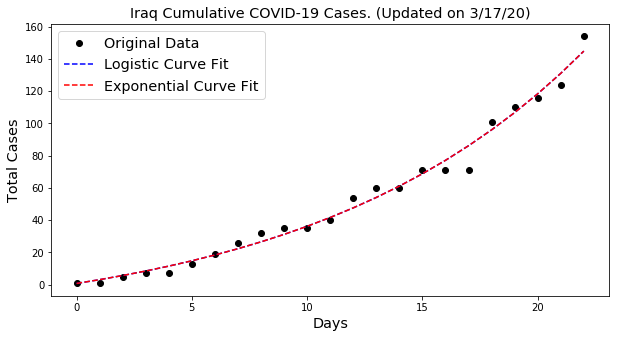



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 142
	Confirmed cases on 3/10/20 	 56
	Ratio: 2.54
	Weekly increase: 153.6 %
	Daily increase: 14.2 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Exponential Fit **

	R^2: 0.984301341136
	Doubling Time (represents overall growth):  4.58 (± 0.36 ) days


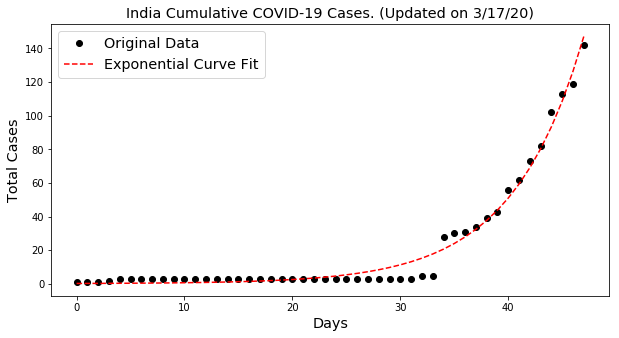



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 140
	Confirmed cases on 3/10/20 	 5
	Ratio: 28.0
	Weekly increase: 2700.0 %
	Daily increase: 61.0 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Exponential Fit **

	R^2: 0.982943995878
	Doubling Time (represents overall growth):  1.74 (± 0.26 ) days


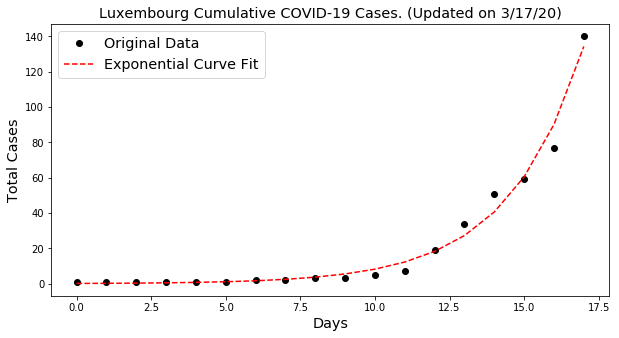



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 130
	Confirmed cases on 3/10/20 	 69
	Ratio: 1.88
	Weekly increase: 88.4 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.7 days


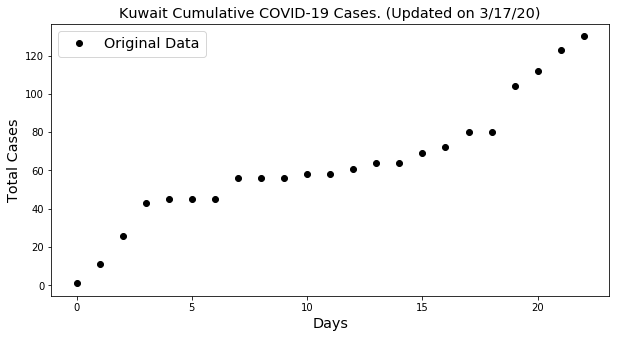



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 120
	Confirmed cases on 3/10/20 	 41
	Ratio: 2.93
	Weekly increase: 192.7 %
	Daily increase: 16.6 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Logistic Fit**

	R^2: 0.987619791448
	Doubling Time (during middle of growth):  4.95 (± 1.3 ) days

** Based on Exponential Fit **

	R^2: 0.97874091171
	Doubling Time (represents overall growth):  5.25 (± 0.91 ) days


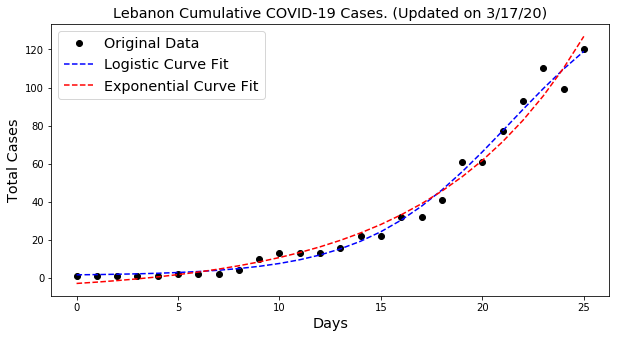



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 117
	Confirmed cases on 3/10/20 	 11
	Ratio: 10.64
	Weekly increase: 963.6 %
	Daily increase: 40.2 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.986837095404
	Doubling Time (during middle of growth):  3.4 (± 2.54 ) days

** Based on Exponential Fit **

	R^2: 0.986837097006
	Doubling Time (represents overall growth):  1.7 (± 0.32 ) days


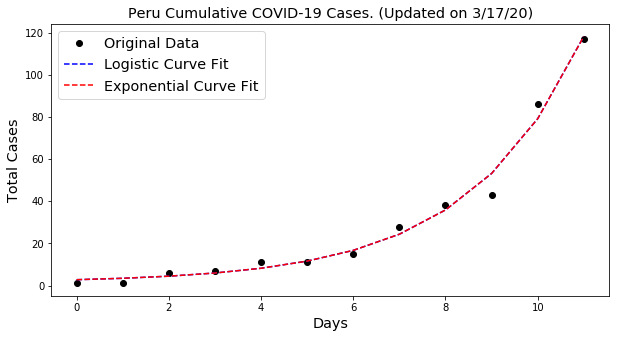



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 114
	Confirmed cases on 3/10/20 	 20
	Ratio: 5.7
	Weekly increase: 470.0 %
	Daily increase: 28.2 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.99225890333
	Doubling Time (represents overall growth):  2.67 (± 0.14 ) days


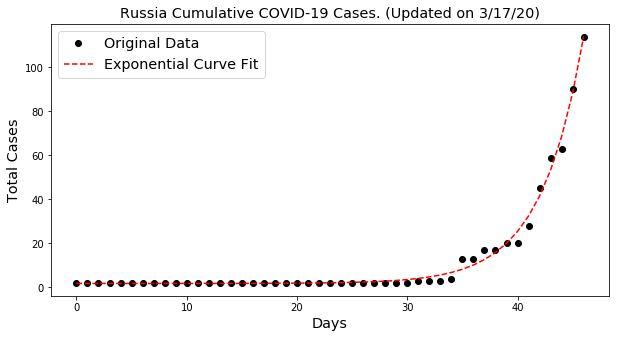



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 109
	Confirmed cases on 3/10/20 	 51
	Ratio: 2.14
	Weekly increase: 113.7 %
	Daily increase: 11.5 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.99196317678
	Doubling Time (during middle of growth):  5.52 (± 1.7 ) days

** Based on Exponential Fit **

	R^2: 0.985353641149
	Doubling Time (represents overall growth):  8.09 (± 2.28 ) days


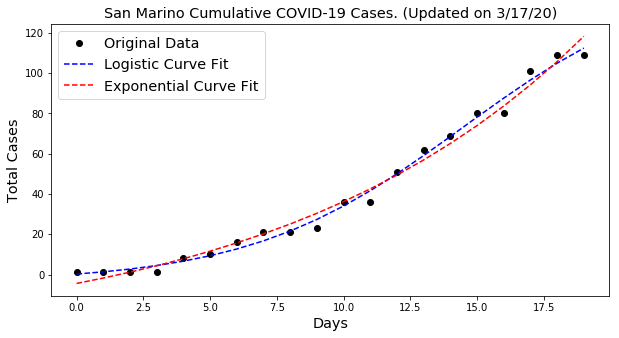

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


         Countries  Inferred Doubling Time  Recent Doubling Time
0            China                     6.5                2297.5
1            Italy                     4.1                   4.3
2             Iran                     6.6                   6.9
3            Spain                     2.6                   2.5
4          Germany                     2.7                   2.6
5     Korea, South                     4.1                  47.6
6           France                     3.2                   3.3
7               US                     2.5                   2.6
8      Switzerland                     3.8                   2.8
9   United Kingdom                     3.0                   3.0
10     Netherlands                     3.5                   3.2
11          

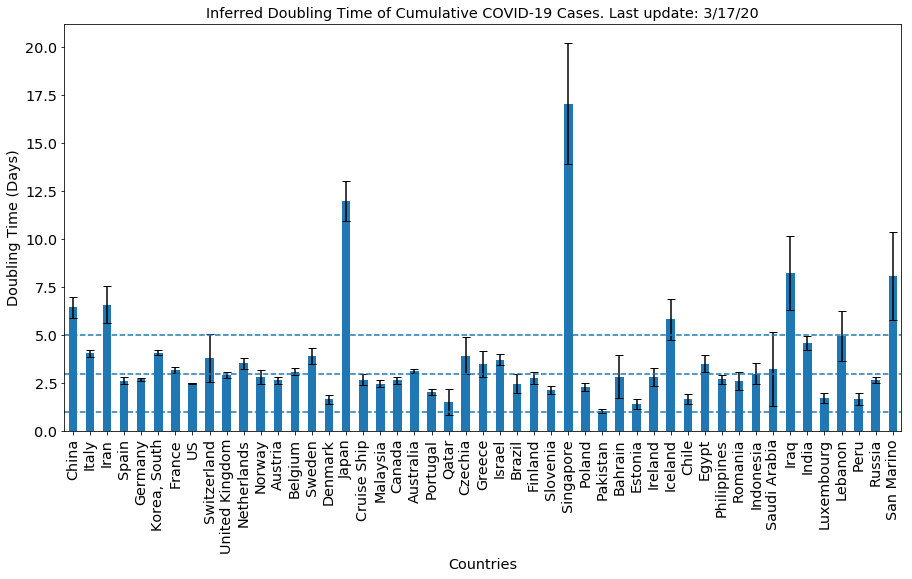

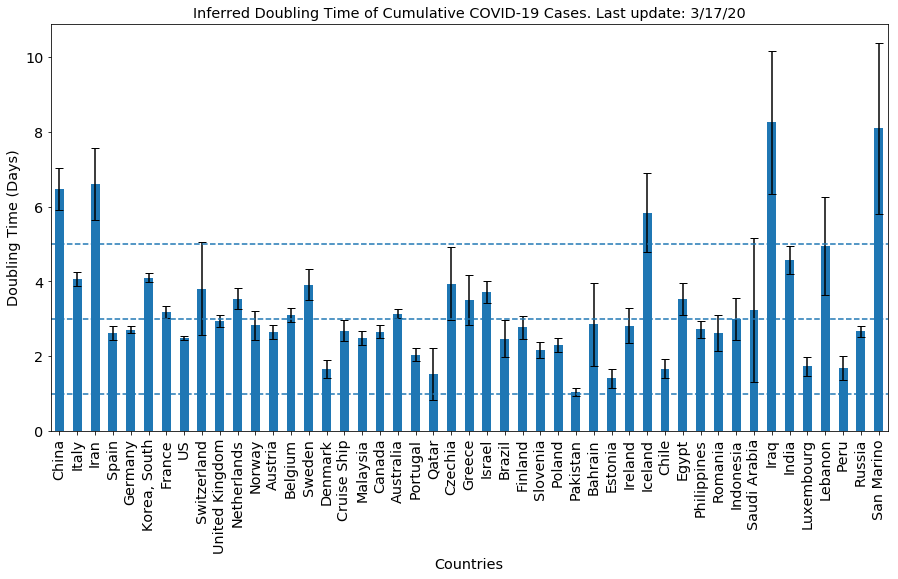

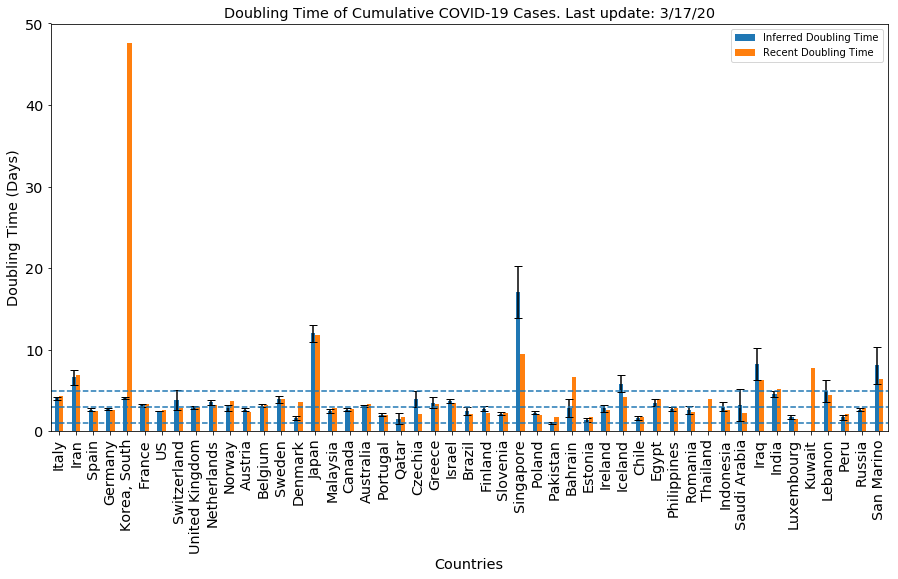

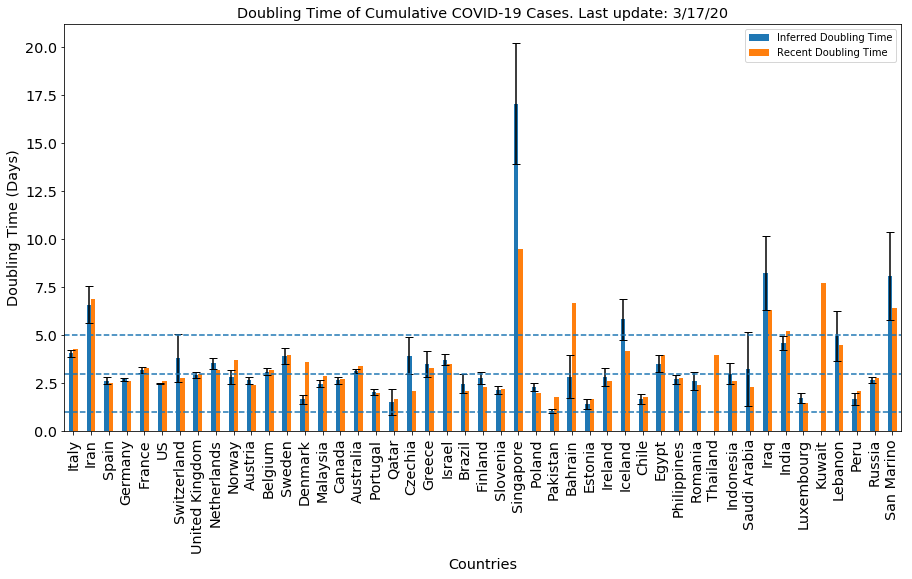

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [7]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/17/20


,3/17/20
Province/State,
New York,1706
Washington,1076
California,698
New Jersey,267
Massachusetts,218
Florida,216
Louisiana,196
Illinois,161
Colorado,160


## Curve Fitting US COVID-19 Cases

                3/17/20
Province/State         
New York           1706
Washington         1076
California          698
New Jersey          267
Massachusetts       218
Florida             216
Louisiana           196
Illinois            161
Colorado            160
Georgia             146
Pennsylvania        112
Texas               110


US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 1706
	Confirmed cases on 3/10/20 	 173
	Ratio: 9.86
	Weekly increase: 886.1 %
	Daily increase: 38.7 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.985797372567
	Doubling Time (during middle of growth):  3.59 (± 0.63 ) days

** Based on Exponential Fit **

	R^2: 0.985797373096
	Doubling Time (represents overall growth):  1.79 (± 0.27 ) days


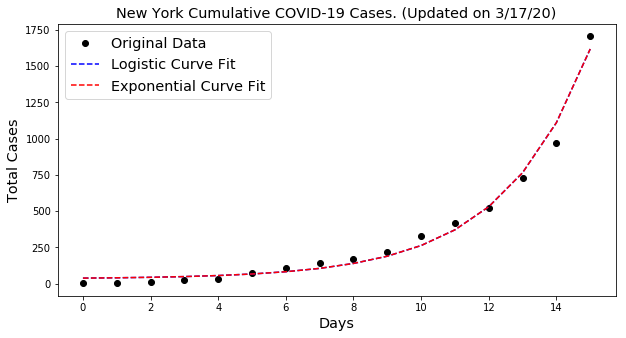



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 1076
	Confirmed cases on 3/10/20 	 267
	Ratio: 4.03
	Weekly increase: 303.0 %
	Daily increase: 22.0 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.987372550299
	Doubling Time (represents overall growth):  3.3 (± 0.21 ) days


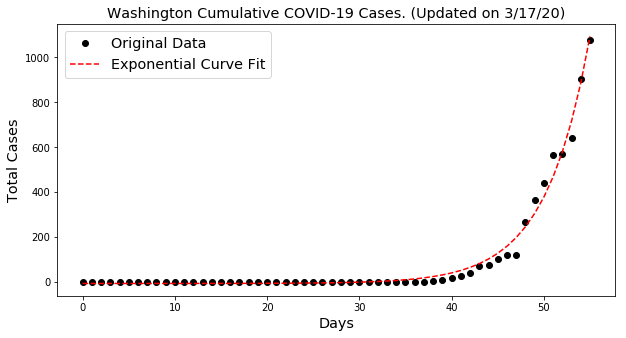



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 698
	Confirmed cases on 3/10/20 	 144
	Ratio: 4.85
	Weekly increase: 384.7 %
	Daily increase: 25.3 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.999172662291
	Doubling Time (represents overall growth):  2.96 (± 0.05 ) days


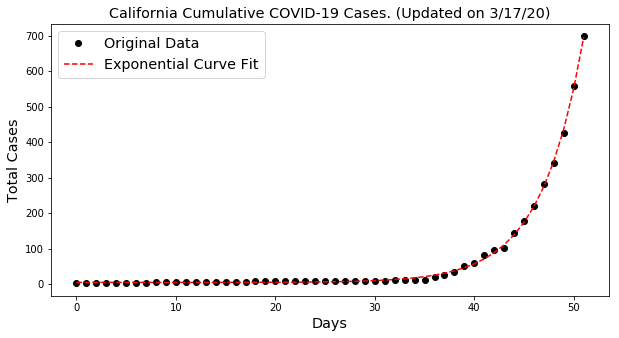



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 267
	Confirmed cases on 3/10/20 	 15
	Ratio: 17.8
	Weekly increase: 1680.0 %
	Daily increase: 50.9 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Logistic Fit**

	R^2: 0.995591174508
	Doubling Time (during middle of growth):  2.44 (± 0.77 ) days

** Based on Exponential Fit **

	R^2: 0.995139641398
	Doubling Time (represents overall growth):  1.45 (± 0.15 ) days


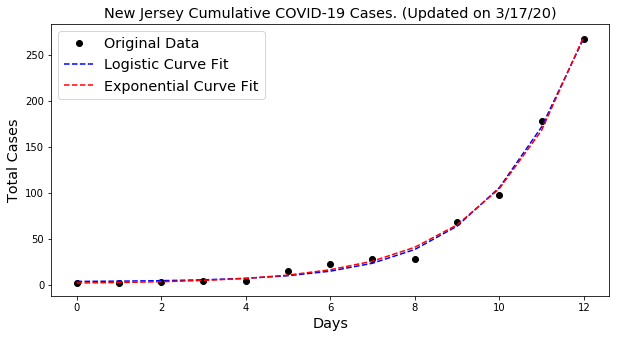



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 218
	Confirmed cases on 3/10/20 	 92
	Ratio: 2.37
	Weekly increase: 137.0 %
	Daily increase: 13.1 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Exponential Fit **

	R^2: 0.960067403943
	Doubling Time (represents overall growth):  3.54 (± 0.45 ) days


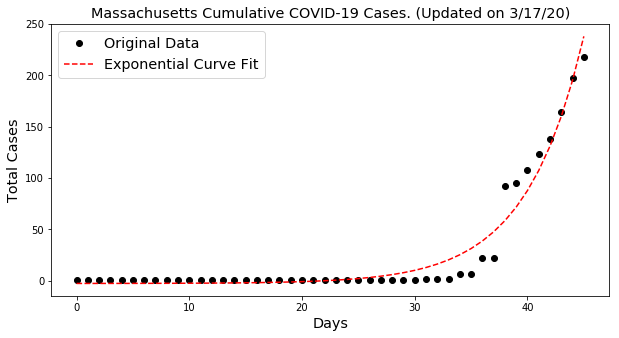



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 216
	Confirmed cases on 3/10/20 	 15
	Ratio: 14.4
	Weekly increase: 1340.0 %
	Daily increase: 46.4 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Logistic Fit**

	R^2: 0.999102446153
	Doubling Time (during middle of growth):  3.34 (± 0.4 ) days

** Based on Exponential Fit **

	R^2: 0.998539595588
	Doubling Time (represents overall growth):  2.0 (± 0.1 ) days


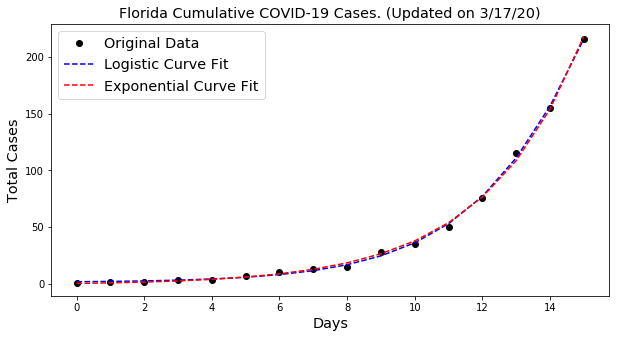



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 196
	Confirmed cases on 3/10/20 	 1
	Ratio: 196.0
	Weekly increase: 19500.0 %
	Daily increase: 112.6 % per day
	Doubling Time (represents recent growth): 0.9 days

** Based on Logistic Fit**

	R^2: 0.992264971339
	Doubling Time (during middle of growth):  3.61 (± 3.61 ) days

** Based on Exponential Fit **

	R^2: 0.992021960329
	Doubling Time (represents overall growth):  2.24 (± 0.55 ) days


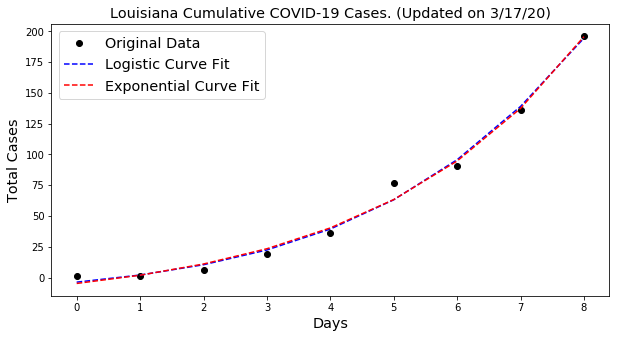



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 161
	Confirmed cases on 3/10/20 	 12
	Ratio: 13.42
	Weekly increase: 1241.7 %
	Daily increase: 44.9 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Exponential Fit **

	R^2: 0.993443567257
	Doubling Time (represents overall growth):  2.12 (± 0.1 ) days


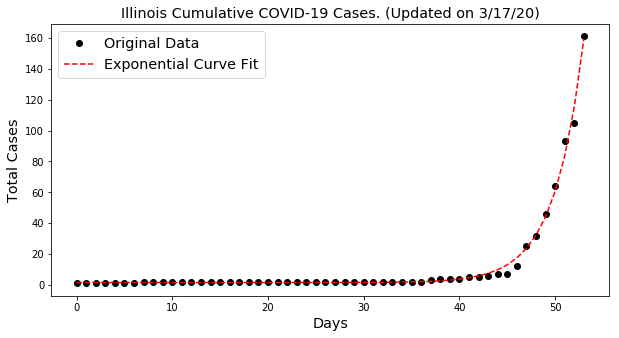



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 160
	Confirmed cases on 3/10/20 	 15
	Ratio: 10.67
	Weekly increase: 966.7 %
	Daily increase: 40.2 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.986965174879
	Doubling Time (during middle of growth):  1.77 (± 0.68 ) days

** Based on Exponential Fit **

	R^2: 0.956678147334
	Doubling Time (represents overall growth):  3.76 (± 2.08 ) days


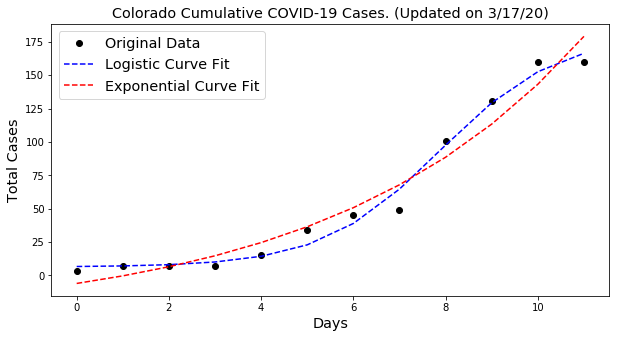



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 146
	Confirmed cases on 3/10/20 	 17
	Ratio: 8.59
	Weekly increase: 758.8 %
	Daily increase: 36.0 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.997430931443
	Doubling Time (during middle of growth):  2.61 (± 0.44 ) days

** Based on Exponential Fit **

	R^2: 0.98925432675
	Doubling Time (represents overall growth):  2.55 (± 0.4 ) days


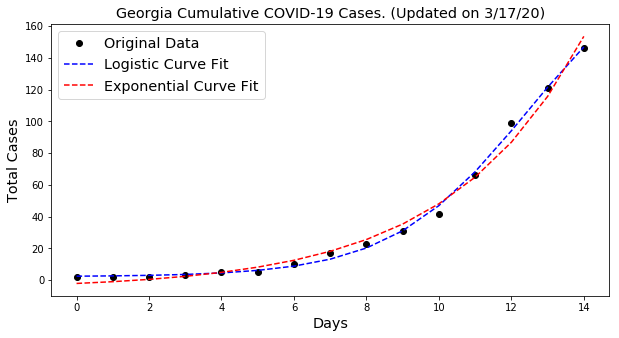



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 112
	Confirmed cases on 3/10/20 	 12
	Ratio: 9.33
	Weekly increase: 833.3 %
	Daily increase: 37.6 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.991616001926
	Doubling Time (during middle of growth):  5.32 (± 5.11 ) days

** Based on Exponential Fit **

	R^2: 0.991616002608
	Doubling Time (represents overall growth):  2.66 (± 0.5 ) days


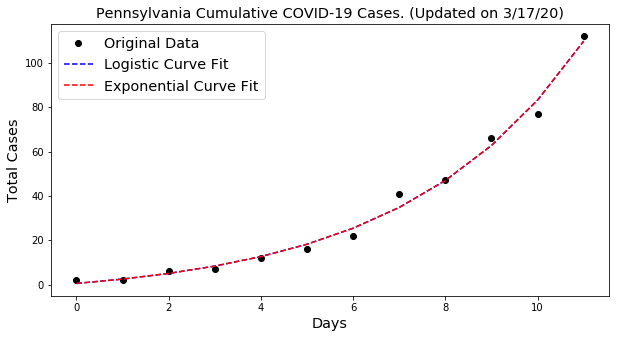



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/17/20 	 110
	Confirmed cases on 3/10/20 	 13
	Ratio: 8.46
	Weekly increase: 746.2 %
	Daily increase: 35.7 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.995653966393
	Doubling Time (during middle of growth):  3.52 (± 1.14 ) days

** Based on Exponential Fit **

	R^2: 0.993152052025
	Doubling Time (represents overall growth):  3.01 (± 0.49 ) days


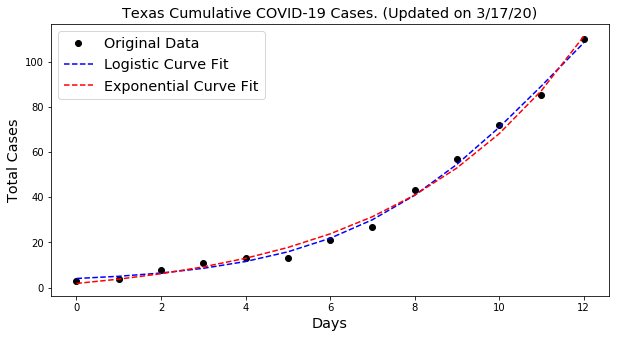

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


           States  Inferred Doubling Time  Recent Doubling Time
0        New York                     1.8                   2.1
1      Washington                     3.3                   3.5
2      California                     3.0                   3.1
3      New Jersey                     1.4                   1.7
4   Massachusetts                     3.5                   5.6
5         Florida                     2.0                   1.8
6       Louisiana                     2.2                   0.9
7        Illinois                     2.1                   1.9
8        Colorado                     1.8                   2.0
9         Georgia                     2.6                   2.3
10   Pennsylvania                     2.7                   2.2
11          Texas       

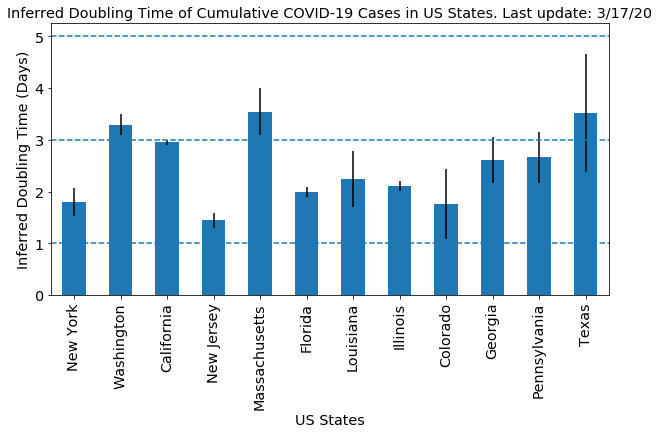

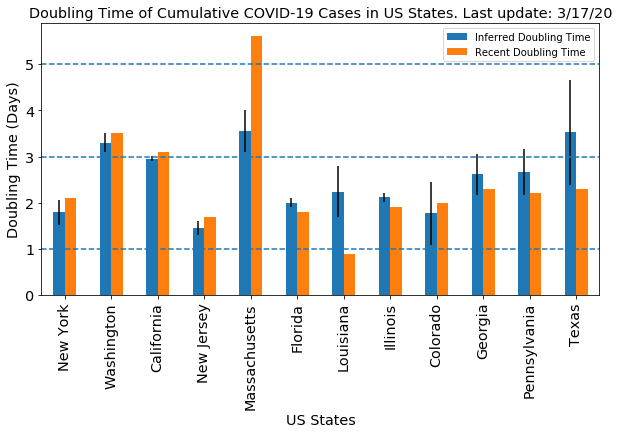

In [9]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()